In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
import yahoo_finance as yahoo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Allows the use of display() for DataFrames


# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Control the default size of figures in this Jupyter notebook
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 9)

###### Entry Parameters #######
#Used for re-running: stops querying the API if we already have the data
reloadData = False
###############################


def prepareData(data):
    #Date and Symbol columns not required
    data.drop(['Symbol'], axis = 1, inplace = True)
    pd.to_datetime(data['Date'])
    df = pd.DataFrame(data)
    df.sort_values(by='Date', ascending=True)
    # make date as an index for pandas data frame for visulizations
    df.set_index('Date',inplace=True)
    return df

    
# returive stock data using yahoo Finance API and return a dataFrame
def retrieveStockData(tickerSymbol, startDate, endDate, fileName):
    try:
        if reloadData:
            print('Retriving data for ticker _' + tickerSymbol + ' ...')
            historical = yahoo.Share(tickerSymbol).get_historical(startDate, endDate)
            
            data = pd.DataFrame(historical)
            #data = data.drop(['Open', 'Close', 'High', 'Low', 'Volume', 'Symbol', 'Date'], axis=1)
            
            # save as CSV to stop blowing up their API
            data['Adj_Close'].to_csv(fileName, index = False)
        else:
            # read the existing csv 
            data = pd.read_csv(fileName)
            data = prepareData(data)
            
        print('Wholesale customers dataset has {} samples with {} features each.'.format(*data.shape))
        return data
    except:
         print('Dataset could not be loaded. Is the dataset missing?')
        

Populating the interactive namespace from numpy and matplotlib


Wholesale customers dataset has 7807 samples with 6 features each.


,Adj_Close,Close,High,Low,Open,Volume
Date,,,,,,
2017-03-01,64.940002,64.940002,64.989998,64.019997,64.129997,26763800
2017-02-28,63.980000,63.980000,64.199997,63.759998,64.080002,23043900
2017-02-27,64.230003,64.230003,64.540001,64.050003,64.540001,15850400
2017-02-24,64.620003,64.620003,64.800003,64.139999,64.529999,21705200
2017-02-23,64.620003,64.620003,64.730003,64.190002,64.419998,20235200


,Adj_Close,Close,High,Low,Open,Volume
Date,,,,,,
1986-03-19,0.066202,28.250000,29.000001,28.000000,28.750000,47894400
1986-03-18,0.067374,28.750000,29.750000,28.500001,29.499999,67766400
1986-03-17,0.069131,29.499999,29.750000,29.000001,29.000001,133171200
1986-03-14,0.067960,29.000001,29.499999,28.000000,28.000000,308160000
1986-03-13,0.065616,28.000000,29.250000,25.499999,25.499999,1031788800


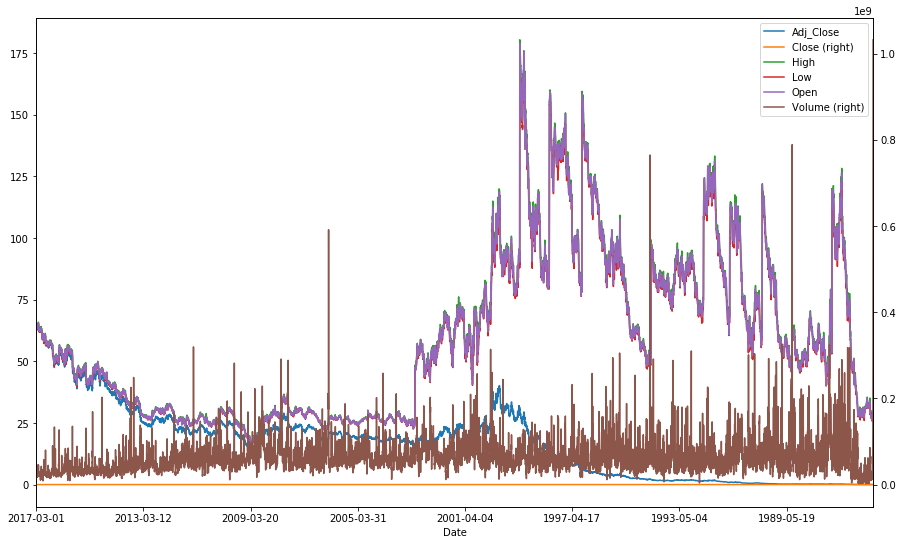

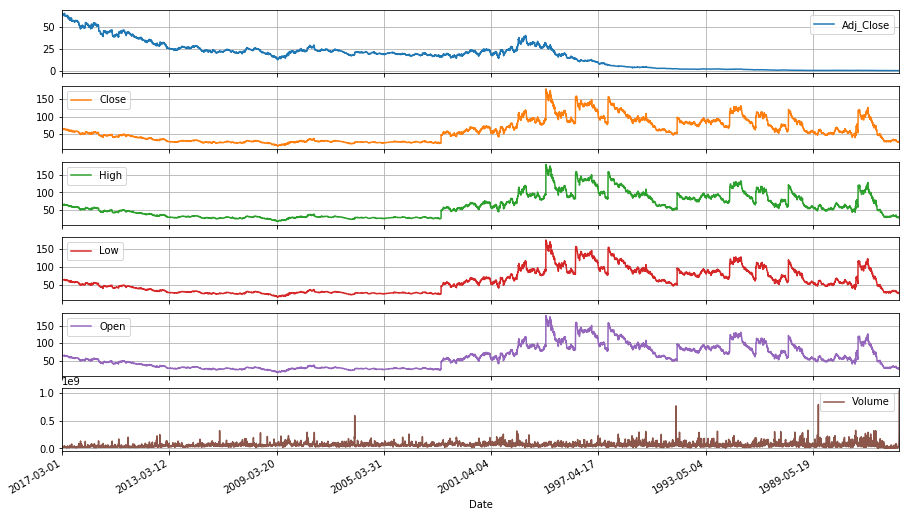

In [28]:
MSFTdata = retrieveStockData('MSFT', '1986-03-13', '2017-03-01', './data/MicrosoftData.csv')
display(MSFTdata.head())
display(MSFTdata.tail())
MSFTdata.plot(secondary_y=['Close', 'Volume'])
MSFTdata.plot(grid = True, subplots=True)
plt.legend(loc='best')

In [32]:
data = MSFTdata
data.head()
data = data.drop(['Open', 'Close', 'High', 'Low', 'Volume'], axis=1)

display(data.head())
            
# save as CSV to stop blowing up their API
#data['Adj_Close'].to_csv(fileName, index = False)

,Adj_Close
Date,
2017-03-01,64.940002
2017-02-28,63.980000
2017-02-27,64.230003
2017-02-24,64.620003
2017-02-23,64.620003


## Build a RNN with LSTM

In [51]:
import os
import time
import warnings
import numpy as np
import time
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(filename, seq_len, normalise_window):
    #f = open(filename, 'rb').read()
    #data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        window = window['Adj_Close']
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [52]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.savefig('results.jpg')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.savefig('multipleResults.jpg')
    plt.show()    

In [53]:
epochs  = 1
seq_len = 50

print('> Loading data... ')

X_train, y_train, X_test, y_test = load_data('./data/Microsoft.csv', seq_len, True)

print('> Data Loaded. Compiling...')

model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=epochs,
    validation_split=0.05)



> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.04660606384277344
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_3 (LSTM)                    (None, None, 50)      10400       lstm_input_2[0][0]               
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, None, 50)      0           lstm_3[0][0]                     
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 100)           60400       dropout_3[0][0]                  
____________________________________________________________________________________________________
dropout_4 (Dropout)              (None, 100)           0           lstm_4[0][0]                     
__

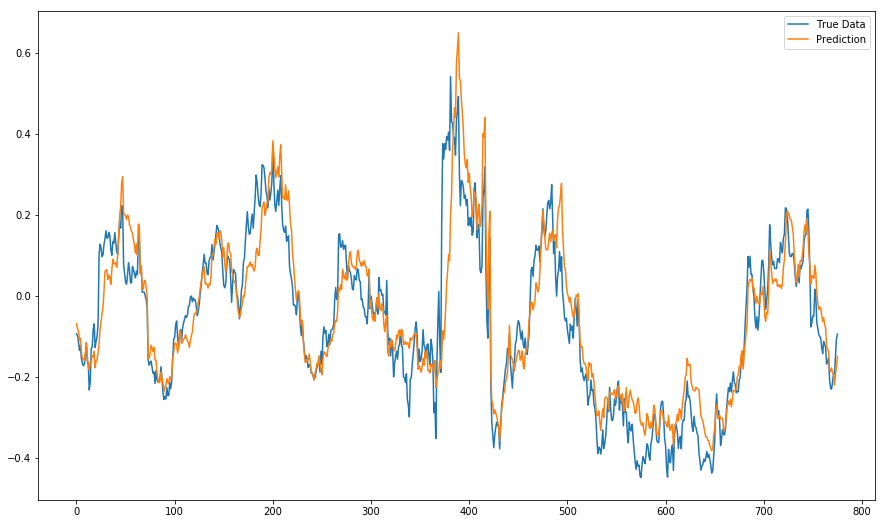

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [55]:
predicted = predict_point_by_point(model, X_test)
plot_results(predicted, y_test)


,0
0,-0.092920
1,-0.096913
2,-0.112332
3,-0.134198
4,-0.122270


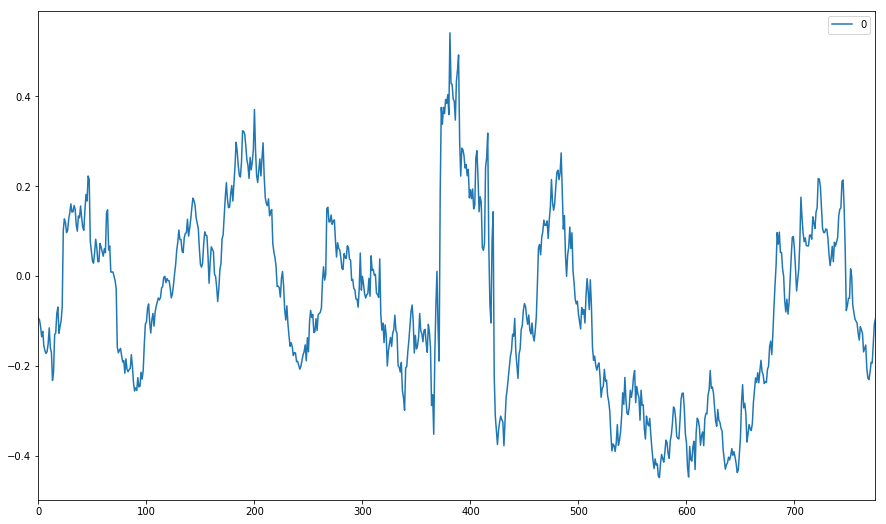

In [62]:
df = pd.DataFrame(y_test)
display(df.head())
df.set_index('0',inplace=True)
df.plot()

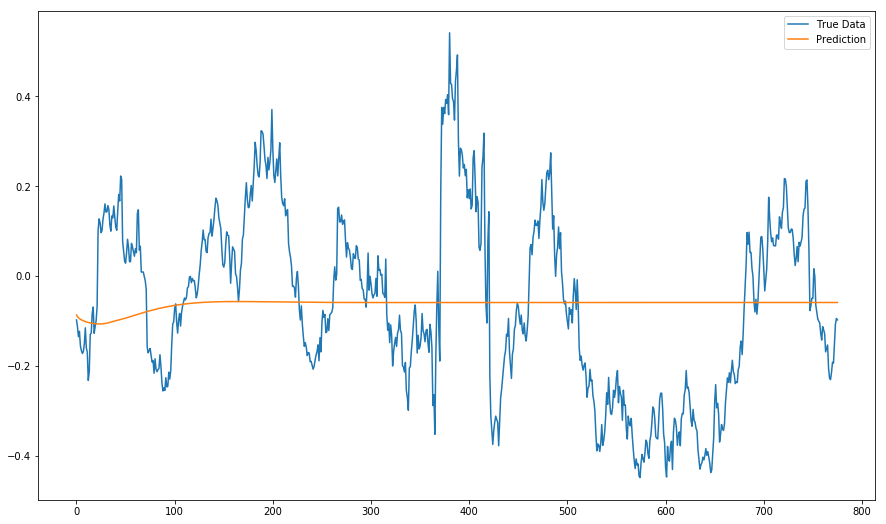

In [10]:
predicted = predict_sequence_full(model, X_test, seq_len)
plot_results(predicted, y_test)

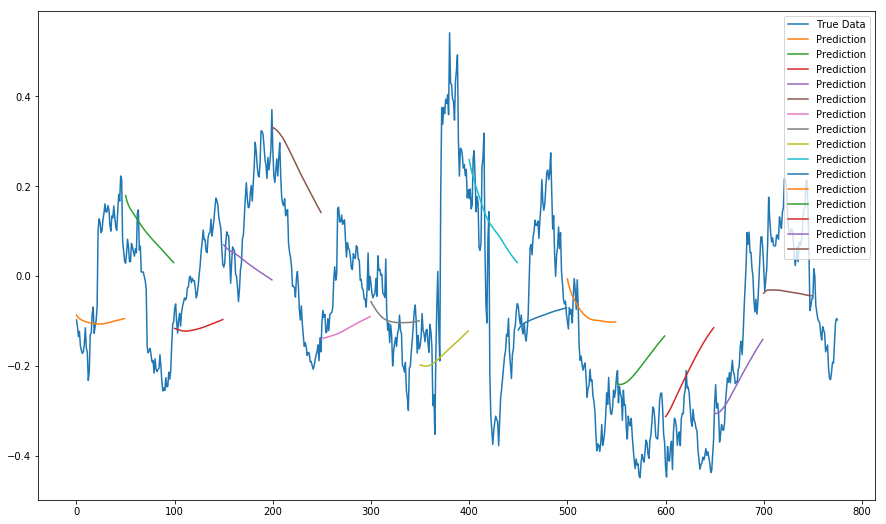

In [11]:
predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
plot_results_multiple(predictions, y_test, 50)